In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%%capture
!pip install wandb --upgrade

In [3]:
!cp drive/MyDrive/Uni/Masterarbeit/data/imputation/* .

BRITS implementation in colab

In [4]:
import os
import time

import numpy as np
import pandas as pd
import pickle

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter

from tqdm import tqdm
import math
import wandb
from datetime import datetime

In [5]:
SEQ_LEN = 28
RNN_HID_SIZE = 64
no_classes = 0
END_REG = 10 #Index at which the regression variables end(exclusive) and the categorical variables start
INPUT_SIZE = END_REG + no_classes

In [6]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') 
    return device
device = get_device()
print(device)

cuda:0


#Network Classes

Other than in the original BRITS, we removed the classification loss, as we do not have a classificaition task. Further we did a hard split into train and test set as it is good practice. The code is based on, but updated, cleaned and converted to Python3:
https://github.com/NIPS-BRITS/BRITS

## Feature Regression and Decay

In [7]:
class FeatureRegression(nn.Module):
    def __init__(self, input_size):
        super(FeatureRegression, self).__init__()
        self.build(input_size)

    def build(self, input_size):
        self.W = Parameter(torch.Tensor(input_size, input_size)).to(device)
        self.b = Parameter(torch.Tensor(input_size)).to(device)

        m = torch.ones(input_size, input_size) - torch.eye(input_size, input_size)
        m = m.to(device)
        self.register_buffer('m', m)

        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.W.size(0))
        self.W.data.uniform_(-stdv, stdv)
        if self.b is not None:
            self.b.data.uniform_(-stdv, stdv)

    def forward(self, x):
        z_h = F.linear(x, self.W * self.m, self.b)
        return z_h

class TemporalDecay(nn.Module):
    def __init__(self, input_size, output_size, diag = False):
        super(TemporalDecay, self).__init__()
        self.diag = diag

        self.build(input_size, output_size)

    def build(self, input_size, output_size):
        self.W = Parameter(torch.Tensor(output_size, input_size)).to(device)
        self.b = Parameter(torch.Tensor(output_size)).to(device)

        if self.diag == True:
            assert(input_size == output_size)
            m = torch.eye(input_size, input_size).to(device)
            self.register_buffer('m', m)

        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.W.size(0))
        self.W.data.uniform_(-stdv, stdv)
        if self.b is not None:
            self.b.data.uniform_(-stdv, stdv)

    def forward(self, d):
        if self.diag == True:
            gamma = F.relu(F.linear(d, self.W * self.m, self.b))
        else:
            gamma = F.relu(F.linear(d, self.W, self.b))
        gamma = torch.exp(-gamma)
        return gamma

## RITS and BRITS

In [8]:
class RITS(nn.Module):
    def __init__(self):
        super(RITS, self).__init__()
        self.build()

    def build(self):
        self.rnn_cell = nn.LSTMCell(INPUT_SIZE * 2, RNN_HID_SIZE).to(device)

        self.temp_decay_h = TemporalDecay(input_size = INPUT_SIZE, output_size = RNN_HID_SIZE, diag = False)
        self.temp_decay_x = TemporalDecay(input_size = INPUT_SIZE, output_size = INPUT_SIZE, diag = True)

        self.hist_reg = nn.Linear(RNN_HID_SIZE, INPUT_SIZE).to(device)
        self.feat_reg = FeatureRegression(INPUT_SIZE).to(device)

        self.weight_combine = nn.Linear(INPUT_SIZE * 2, INPUT_SIZE).to(device)

        self.dropout = nn.Dropout(p = 0.25).to(device)
        self.out = nn.Linear(RNN_HID_SIZE, 1).to(device)

    def forward(self, data, direct, is_test = False):
        values = data[direct]['values'].to(device)
        masks = data[direct]['masks'].to(device)
        deltas = data[direct]['deltas'].to(device)
        
        evals = None
        eval_masks = None
        if not is_test:
          evals = data[direct]['evals'].to(device)
          eval_masks = data[direct]['eval_masks'].to(device)

        h = torch.zeros((values.size()[0], RNN_HID_SIZE)).to(device)
        c = torch.zeros((values.size()[0], RNN_HID_SIZE)).to(device)
          

        x_loss = torch.FloatTensor([0.0]).to(device)
        cat_loss = torch.FloatTensor([0.0]).to(device)

        imputations = []

        for t in range(SEQ_LEN):
            x = values[:, t, :]
            m = masks[:, t, :]
            d = deltas[:, t, :]

            gamma_h = self.temp_decay_h(d)
            gamma_x = self.temp_decay_x(d)

            h = h * gamma_h

            x_h = self.hist_reg(h)#(1)
            x_loss += torch.sum(torch.abs(x - x_h) * m) / (torch.sum(m) + 1e-5)#(5)

            x_c =  m * x +  (1 - m) * x_h #(2)

            z_h = self.feat_reg(x_c) #(7) Estimation regarding current timestep features 
            x_loss += torch.sum(torch.abs(x - z_h) * m) / (torch.sum(m) + 1e-5)

            alpha = self.weight_combine(torch.cat([gamma_x, m], dim = 1)) #(8)called beta in paper: Wheight that combines history based estimation x_h and feature based estimation z_h

            c_h = alpha * z_h + (1 - alpha) * x_h
            x_loss += torch.sum(torch.abs(x - c_h) * m) / (torch.sum(m) + 1e-5)

            c_c = m * x + (1 - m) * c_h # 10 

            inputs = torch.cat([c_c, m], dim = 1)

            h, c = self.rnn_cell(inputs, (h, c)) #RNN step

            imputations.append(c_c.unsqueeze(dim = 1))

        imputations = torch.cat(imputations, dim = 1)

        return {'loss': x_loss / SEQ_LEN,
                'x_loss': x_loss/ SEQ_LEN,
                'cat_loss': cat_loss / SEQ_LEN,
                'imputations': imputations,
                'evals': evals, 
                'eval_masks': eval_masks}

    def run_on_batch(self, data, optimizer):
        ret = self(data, direct = 'forward')

        if optimizer is not None:
            optimizer.zero_grad()
            ret['loss'].backward()
            optimizer.step()

        return ret

In [9]:
"""
class RITS(nn.Module):
    def __init__(self):
        super(RITS, self).__init__()
        self.build()

    def build(self):
        self.rnn_cell = nn.LSTMCell(INPUT_SIZE * 2, RNN_HID_SIZE).to(device)

        self.temp_decay_h = TemporalDecay(input_size = INPUT_SIZE, output_size = RNN_HID_SIZE, diag = False)
        self.temp_decay_x = TemporalDecay(input_size = INPUT_SIZE, output_size = INPUT_SIZE, diag = True)

        self.hist_reg = nn.Linear(RNN_HID_SIZE, INPUT_SIZE).to(device)
        self.feat_reg = FeatureRegression(INPUT_SIZE).to(device)

        self.weight_combine = nn.Linear(INPUT_SIZE * 2, INPUT_SIZE).to(device)

        self.dropout = nn.Dropout(p = 0.25).to(device)
        self.out = nn.Linear(RNN_HID_SIZE, 1).to(device)

    def forward(self, data, direct, is_test = False):
        values = data[direct]['values'].to(device)
        masks = data[direct]['masks'].to(device)
        deltas = data[direct]['deltas'].to(device)
        
        evals = None
        eval_masks = None
        if not is_test:
          evals = data[direct]['evals'].to(device)
          eval_masks = data[direct]['eval_masks'].to(device)

        h = torch.zeros((values.size()[0], RNN_HID_SIZE)).to(device)
        c = torch.zeros((values.size()[0], RNN_HID_SIZE)).to(device)
          

        x_loss = torch.FloatTensor([0.0]).to(device)
        cat_loss = torch.FloatTensor([0.0]).to(device)

        imputations = []

        for t in range(SEQ_LEN):
            x = values[:, t,:]
            m = masks[:, t,:]
            d = deltas[:, t,:]

            gamma_h = self.temp_decay_h(d)
            gamma_x = self.temp_decay_x(d)

            h = h * gamma_h

            x_h = self.hist_reg(h)

            x_loss += torch.sum(torch.abs(x[:,:END_REG] - x_h[:,:END_REG]) * m[:,:END_REG]) / (torch.sum(m[:,:END_REG]) + 1e-5)
            x_c =  m * x +  (1 - m) * x_h # (1) take all actual values from x and all missing from approximation x_h (xhat)

            z_h = self.feat_reg(x_c) # (7) in paper
            x_loss += torch.sum(torch.abs(x[:,:END_REG] - z_h[:,:END_REG]) * m[:,:END_REG]) / (torch.sum(m[:,:END_REG]) + 1e-5)

            alpha = self.weight_combine(torch.cat([gamma_x, m], dim = 1))# called beta in the paper wheigh

            c_h = alpha * z_h + (1 - alpha) * x_h #(9)
            x_loss += torch.sum(torch.abs(x[:,:END_REG] - c_h[:,:END_REG]) * m[:,:END_REG]) / (torch.sum(m[:,:END_REG]) + 1e-5)

            #categorical loss only if there are categorical values
            if END_REG < INPUT_SIZE:
              filter = [m[:,END_REG:]==1]
              x_filter = x[:,END_REG:][filter]
              c_h_filter = c_h[:,END_REG:][filter]
              cat_loss += F.binary_cross_entropy_with_logits(c_h_filter,x_filter)

            c_c = m * x + (1 - m) * c_h

            inputs = torch.cat([c_c, m], dim = 1)

            h, c = self.rnn_cell(inputs, (h, c))
            imputations.append(c_c.unsqueeze(dim = 1))

        imputations = torch.cat(imputations, dim = 1)

        return {'loss': (x_loss+cat_loss) / SEQ_LEN,
                'x_loss': x_loss/ SEQ_LEN,
                'cat_loss': cat_loss / SEQ_LEN,
                'imputations': imputations,
                'evals': evals, 
                'eval_masks': eval_masks}

    def run_on_batch(self, data, optimizer):
        ret = self(data, direct = 'forward')

        if optimizer is not None:
            optimizer.zero_grad()
            ret['loss'].backward()
            optimizer.step()

        return ret
"""

"\nclass RITS(nn.Module):\n    def __init__(self):\n        super(RITS, self).__init__()\n        self.build()\n\n    def build(self):\n        self.rnn_cell = nn.LSTMCell(INPUT_SIZE * 2, RNN_HID_SIZE).to(device)\n\n        self.temp_decay_h = TemporalDecay(input_size = INPUT_SIZE, output_size = RNN_HID_SIZE, diag = False)\n        self.temp_decay_x = TemporalDecay(input_size = INPUT_SIZE, output_size = INPUT_SIZE, diag = True)\n\n        self.hist_reg = nn.Linear(RNN_HID_SIZE, INPUT_SIZE).to(device)\n        self.feat_reg = FeatureRegression(INPUT_SIZE).to(device)\n\n        self.weight_combine = nn.Linear(INPUT_SIZE * 2, INPUT_SIZE).to(device)\n\n        self.dropout = nn.Dropout(p = 0.25).to(device)\n        self.out = nn.Linear(RNN_HID_SIZE, 1).to(device)\n\n    def forward(self, data, direct, is_test = False):\n        values = data[direct]['values'].to(device)\n        masks = data[direct]['masks'].to(device)\n        deltas = data[direct]['deltas'].to(device)\n        \n        

In [10]:
class BRITS(nn.Module):
    def __init__(self):
        super(BRITS, self).__init__()
        self.build()

    def build(self):
        self.rits_f = RITS()
        self.rits_b = RITS()

    def forward(self, data, is_test = False):
        ret_f = self.rits_f(data, 'forward',is_test)
        ret_b = self.reverse(self.rits_b(data, 'backward',is_test))

        ret = self.merge_ret(ret_f, ret_b)

        return ret

    def merge_ret(self, ret_f, ret_b):
        loss_f = ret_f['loss']
        loss_b = ret_b['loss']
        loss_c = self.get_consistency_loss(ret_f['imputations'], ret_b['imputations'])

        loss = loss_f + loss_b + loss_c

        imputations = (ret_f['imputations'] + ret_b['imputations']) / 2

        ret_f['loss'] = loss
        ret_f['imputations'] = imputations

        return ret_f

    def get_consistency_loss(self, pred_f, pred_b):
        #loss old:
        #loss = torch.pow(pred_f - pred_b, 2.0).mean()
        #return loss
        loss = torch.abs(pred_f - pred_b).mean() * 1e-1
        return loss

    def reverse(self, ret):
        def reverse_tensor(tensor_):
            if tensor_ is None:
              return tensor_
            if tensor_.dim() <= 1:
                return tensor_
            indices = range(tensor_.size()[1])[::-1]
            indices = torch.tensor(indices, requires_grad=False).long()#.requires_grad_(requires_grad=False) 

            if torch.cuda.is_available():
                indices = indices.cuda()

            return tensor_.index_select(1, indices)

        for key in ret:
            ret[key] = reverse_tensor(ret[key])

        return ret

    def run_on_batch(self, data, optimizer):
        ret = self(data)

        if optimizer is not None:
            optimizer.zero_grad()
            ret['loss'].backward()
            optimizer.step()

        return ret

# Dataset

The Data is strucutred as follows:
Each Entry in the Dataset is one Timeseries with n steps.
It has a `forward` and a `backward` direction. For the both RITS Networks
Each has following entries:

*   `values`: data after elimination of values
*   `masks`: indicating if data is missing
*   `deltas`: timedeltas since last recorded data
*   `evals`: ground truth
*   `eval_masks`: 1 if is ground truth and missing in values 0 otherwise

In [11]:
data_set_dict_entries=['values','masks','deltas','evals','eval_masks']

class BRITSCategoriesSet(Dataset):
    def __init__(self,content_path):
        super(BRITSCategoriesSet, self).__init__()
        content = open(content_path,'rb')
        recs = pickle.load(content)
        content.close()
        self.forward = self.to_tensor_dict([x['forward'] for x in recs])
        self.backward = self.to_tensor_dict([x['backward'] for x in recs])

    def __len__(self):
        return len(self.forward[data_set_dict_entries[0]])
    
    def to_tensor_dict(self,recs):
      return_dict = {}
      for dict_key in data_set_dict_entries:
        tens = torch.FloatTensor([[x[dict_key][:END_REG]for x in r]for r in recs])
        bam = torch.zeros(len(recs),SEQ_LEN,no_classes)
        for idx,r in enumerate(recs):
          for idx2,x in enumerate(r):
            if dict_key in ('masks','deltas','eval_masks'):
              bam[idx][idx2] = x[dict_key][END_REG]
            else:  
              bam[idx][idx2] = 0
              for cat in x[dict_key][END_REG:]:
                cat = int(cat)
                if cat == -1:
                  continue
                bam[idx][idx2] += F.one_hot(torch.Tensor([cat]).to(torch.int64),no_classes).squeeze()
        return_dict[dict_key] = torch.cat((tens,bam),dim=2) 
      return return_dict
    
    def __getitem__(self, idx):
      forward = {}
      backward = {}
      for dict_key in data_set_dict_entries:
        forward[dict_key] = self.forward[dict_key][idx]
        backward[dict_key] = self.backward[dict_key][idx]
      return {'forward':forward,'backward':backward}


class BRITSSet(Dataset):
    def __init__(self,content_path):
        super(BRITSSet, self).__init__()
        content = open(content_path,'rb')
        recs = pickle.load(content)
        content.close()
        self.forward = self.to_tensor_dict([x['forward'] for x in recs])
        self.backward = self.to_tensor_dict([x['backward'] for x in recs])

    def __len__(self):
        return len(self.forward[data_set_dict_entries[0]])
    
    def to_tensor_dict(self,recs):
      return_dict = {}
      for dict_key in data_set_dict_entries:
        tens = torch.FloatTensor([[x[dict_key][0:INPUT_SIZE]for x in r]for r in recs])
        return_dict[dict_key] = tens 
      return return_dict
    
    def __getitem__(self, idx):
      forward = {}
      backward = {}
      for dict_key in data_set_dict_entries:
        forward[dict_key] = self.forward[dict_key][idx]
        backward[dict_key] = self.backward[dict_key][idx]
      return {'forward':forward,'backward':backward}

def collate_fn(recs):
  batch_size = len(recs)
  forward = {}
  backward = {}
  for dict_key in data_set_dict_entries:
      forward[dict_key] = torch.empty(batch_size,SEQ_LEN,INPUT_SIZE)
      backward[dict_key] = torch.empty(batch_size,SEQ_LEN,INPUT_SIZE)
  for idx,x in enumerate(recs):
    for dict_key in data_set_dict_entries:
      forward[dict_key][idx] = x['forward'][dict_key]
      backward[dict_key][idx] = x['backward'][dict_key] 
  return {'forward': forward, 'backward': backward}

# Error Functions

In [12]:
indexes= {'calories':1,'carbs':2,'fat':3,'protein':4}
def load_normalizations(file):
  content = open(file,'rb')
  ret = pickle.load(content)
  content.close()
  return ret
normalizations = load_normalizations('brits_normalization.pickle')

def revert_norm(value,name):
  if not use_norm:
    #only if we actually use normalized data
    return value
  return value * normalizations['std'][name] + normalizations['mean'][name]

def get_missing_and_index(data, index_name):
  index = indexes[index_name]
  filter = (data['forward']['eval_masks'][:,:,index]==1) #get all rows that are missing to compare to ground truth
  return index,filter

def print_impu_real(ret,index_name):
  index, filter = get_missing_and_index(data, index_name)
  impu = revert_norm(ret['imputations'][:,:,index][filter],index_name)
  real = revert_norm(ret['evals'][:,:,index][filter],index_name)
  px = pd.DataFrame()
  px.insert(0,"Real",real.cpu().numpy())
  px.insert(0,"Imputation",impu.cpu().detach().numpy())
  return px

def get_abs_error_val(ret, data, index_name):
  """Calculates the absolute error of the brits imputation for each missing value and returns the mean error"""
  index, filter = get_missing_and_index(data, index_name)
  impu = revert_norm(ret['imputations'][:,:,index][filter],index_name).cpu()
  real = revert_norm(data['forward']['evals'][:,:,index][filter],index_name).cpu()
  abs = torch.abs(impu-real)
  return abs.mean().item(),abs.std().item()

def get_abs_personal_mean_impu_error(data,index_name):
  """Calculates the absolute error of the personal mean imputation for each missing value and returns the mean error"""
  index = indexes[index_name]
  forward = data['forward']
  error = torch.tensor(())
  for x in range(forward['eval_masks'].size(dim=0)):
    filter = (forward['eval_masks'][x,:,index]==1)#get all rows that are missing
    z =  revert_norm(forward['values'][x,:,index][filter==False],index_name).mean()#calculate the mean of all non missing
    real =  revert_norm(forward['evals'][x,:,index][filter],index_name)
    error = torch.cat((error,torch.abs(real-z)), dim=0)
  return error.mean().item(),error.std().item()

def get_impu_and_real(data,index_name):
  """Returns the imputated and the real value for all missing for a specific index"""
  index, filter = get_missing_and_index(data, index_name)
  impu = revert_norm(ret['imputations'][:,:,index][filter],index_name).cpu().detach().numpy()
  real = revert_norm(data['forward']['evals'][:,:,index][filter],index_name).cpu().detach().numpy()
  return impu,real

def get_abs_mean_impu_error(data,index_name):
  """Calculates the absolute error of the mean imputation for each missing value and returns the mean error"""
  index, filter = get_missing_and_index(data, index_name)
  forward = data['forward']
  z =  revert_norm(forward['values'][:,:,index][filter==False],index_name).mean()#calculate the mean of all non missing
  real =  revert_norm(forward['evals'][:,:,index][filter],index_name)
  abs = torch.abs(real-z)
  return abs.mean().item(),abs.std().item()

def get_abs__meal_mean_impu_error(data,index_name):
  index, filter = get_missing_and_index(data, index_name)
  forward = data['forward']
  meal_means = {}
  for x in range(1,5):
    meal_index = 0
    #mean of specific meal 
    meal_mean = revert_norm(forward['values'][:,:,index][(forward['evals'][:,:,meal_index]==x)&(filter==False)],index_name).mean().item()
    meal_means[x] = meal_mean
  meals = forward['evals'][:,:,meal_index][filter] #meals of all missing
  real =  revert_norm(forward['evals'][:,:,index][filter],index_name)
  aprox = torch.empty(len(meals))
  for x in range(len(meals)):
    aprox[x] = meal_means[int(meals[x].item())]
  abs = torch.abs(real-aprox)
  return abs.mean().item(),abs.std().item()


def get_rel_error_val(ret, data, index_name):
  """Calculates the relative error of the brits imputation for each missing value and returns the mean error
  It uses the normalized values to remove problems with 0 division
  """
  index, filter = get_missing_and_index(data, index_name)
  impu = ret['imputations'][:,:,index][filter]
  real = data['evals'][:,:,index][filter]
  return torch.abs((impu-real)/(torch.abs(real)+1)).mean().item()

def get_errors_impu(ret,data):
  return_dict = {}
  for index_name in indexes.keys():
    #rel_err = get_rel_error_val(ret,index_name)
    abs_err,_ = get_abs_error_val(ret, data, index_name)
    return_dict[index_name] = abs_err
  return return_dict

def get_errors_bench(data):
  ret = {}
  for index_name in indexes.keys():
    abs_err = get_abs_mean_impu_error(data,index_name)
    ret[index_name] = abs_err
  return ret
def clean_data(data):
  """Removes eval and eval_masks from data before sending it to the model"""
  forward_clean = data['forward'].copy()
  backward_clean = data['backward'].copy()
  del forward_clean['evals']
  del forward_clean['eval_masks']
  del backward_clean['evals']
  del backward_clean['eval_masks']
  return {'forward':forward_clean,'backward': backward_clean}

#Training

In [13]:
use_norm = True
path_train = './brits_train.pickle'
path_test = './brits_test.pickle'
if not use_norm:
  path_train = './brits_train_nonnorm.pickle'
  path_test = './brits_test_nonnorm.pickle'
test_set = BRITSSet(path_test)
train_set = BRITSSet(path_train)
#test_set = BRITSCategoriesSet(path_test)
#train_set = BRITSCategoriesSet(path_train)

if len(test_set) == len(train_set):
  raise Exception("Length of test and train set are equal. Is there a Mistake?")

In [14]:
test_set[0]['forward']['values'].shape

torch.Size([28, 10])

In [15]:
config = dict(
    lr = 1e-3,
    batch_size= 10000,
    use_norm = use_norm,
    num_workers=2,
    dataset="My Fitnesspal Enorm only 151484",
    epochs=1200,
    test_set_size= len(test_set),
    train_set_size= len(train_set)
)

In [16]:
use_wandb = True
if use_wandb:
  wandb.login()
  run = wandb.init(project="brits-enorm", entity="gege-hoho",name="no categories", config=config)
print(f"Test Set Size: {len(test_set)}")
print(f"Train Set Size: {len(train_set)}")

wandb: Currently logged in as: gege-hoho (use `wandb login --relogin` to force relogin)


Test Set Size: 1344
Train Set Size: 12378


In [17]:
model = BRITS()
optimizer = optim.Adam(model.parameters(), lr = config['lr'] )

train_iter = DataLoader(dataset = train_set,batch_size = config['batch_size'],
                        shuffle = True,pin_memory = True, 
                        collate_fn = collate_fn, 
                        num_workers=config["num_workers"])

test_iter = DataLoader(dataset = test_set,batch_size = config['batch_size'],shuffle = False,pin_memory = True, collate_fn = collate_fn)

In [18]:
best_errors = None
early_stopping_dev = 0.05

In [19]:
t0 = time.time()
early_stopping = False
last_errors = {}
for epoch in tqdm(range(config['epochs'])):
  model.train()
  train_loss = 0.0
  for idx, data in enumerate(train_iter):
    ret = model.run_on_batch(data, optimizer)
    train_loss += ret['loss'].item()
  train_loss = train_loss/(idx + 1.0)
  if use_wandb:
    wandb.log({"train-loss": train_loss})


  model.eval()
  test_loss = 0.0
  for idx,data in enumerate(test_iter):
    data_clean = clean_data(data)
    ret = model(data_clean,is_test=True)
    test_loss += ret['loss'].item()
  test_loss = test_loss/(idx+ 1.0)
  test_errors = get_errors_impu(ret,data)
  if use_wandb:
    wandb.log({"test-loss": test_loss})
    wandb.log({"test-errors": test_errors})
    #wandb.log({"cat_loss": ret['cat_loss']})
    #wandb.log({"x_loss": ret['x_loss']})
  else:
    print(test_errors)
  
  #early stopping
  if best_errors is None:
    best_errors = test_errors.copy()
  for k,v in test_errors.items():
    if best_errors[k] > v:
      best_errors[k] = v
    if best_errors[k] * (1.0 + early_stopping_dev) < v:
      print(f"Key {k} deviates to strong from best measured value: {((v*1.0)/best_errors[k]):.2f}")
      print(f"Best measured: {best_errors[k]:.2f}")
      print(f"Current: {v:.2f}")
      early_stopping = True
  if early_stopping:
    early_stopping = False
    break

print("\n")
print(f"{device} {time.time()-t0}")

100%|██████████| 1200/1200 [35:51<00:00,  1.79s/it]




cuda:0 2151.5631849765778


# Testing against MEAN

In [20]:
#data['forward']['values'][get_missing_and_index(data, 'carbs')[1]]

In [21]:
test_iter = DataLoader(dataset = test_set,batch_size = config['batch_size'],shuffle = False,pin_memory = True, collate_fn = collate_fn)
model.eval()
for idx, data in enumerate(test_iter):
    data_clean = clean_data(data)
    ret = model(data_clean,is_test=True)
    break
#index_name = 'calories'
for index_name,_ in indexes.items():
  mean_erro = get_abs_mean_impu_error(data,index_name)
  personal_mean_erro = get_abs_personal_mean_impu_error(data,index_name)
  meal_impu_erro = get_abs__meal_mean_impu_error(data,index_name)
  rnn_erro = get_abs_error_val(ret,data,index_name)


  print(f"{index_name}:")
  print(f"RNN    {rnn_erro}")
  print(f"MEAN   {mean_erro}")
  print(f"MEANP  {personal_mean_erro}")
  print(f"MEANM  {meal_impu_erro}")
  print("")

calories:
RNN    (191.7609405517578, 206.3887176513672)
MEAN   (268.01751708984375, 245.19027709960938)
MEANP  (262.71527099609375, 248.95050048828125)
MEANM  (254.31103515625, 231.03799438476562)

carbs:
RNN    (26.485279083251953, 33.41450881958008)
MEAN   (34.67216110229492, 37.2568473815918)
MEANP  (31.26945686340332, 35.198184967041016)
MEANM  (34.255088806152344, 36.918174743652344)

fat:
RNN    (10.056269645690918, 10.975098609924316)
MEAN   (13.590571403503418, 11.915566444396973)
MEANP  (12.895045280456543, 11.977263450622559)
MEANM  (13.06485366821289, 11.494646072387695)

protein:
RNN    (13.211788177490234, 13.00518798828125)
MEAN   (19.376028060913086, 15.400408744812012)
MEANP  (17.34624671936035, 15.054187774658203)
MEANM  (17.823034286499023, 14.665846824645996)



In [22]:
g_drive_path = '/content/drive/MyDrive/Uni/Masterarbeit/data/britsmodels'
torch.save(model,f"{g_drive_path}/brits{config['dataset']}{datetime.now()}")
run.finish()

test-loss,█▇▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train-loss,█▇▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test-loss,31.80884
train-loss,31.47619


In [25]:
impu, real = get_impu_and_real(data,'calories')

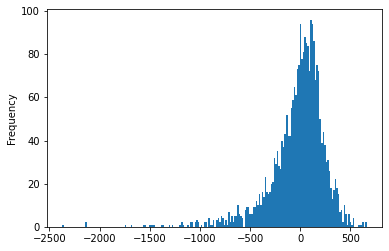

In [26]:
x  = pd.DataFrame({'impu': impu,'real':real,'error': impu-real,'abs_error':np.abs(impu-real)})
x.sort_values(by=['error'])
x['error'].plot.hist(bins=200)